<a href="https://colab.research.google.com/github/mixkunanon/Quant-ML-/blob/main/Time_Series_Stock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock Prediction using ML/DL

## import module and libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn import tree

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_predict

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Import Dataset

In [ ]:
#dataframe stock
df_bp = pd.read_csv('/content/gdrive/MyDrive/Pi data/BANPU.csv')
#drop index
df_bp = df_bp.drop(columns = ['_id','Symbol'])
#datetime dtype
df_bp['updated_at'] = pd.to_datetime(df_bp['updated_at'])
#set date to index
df_bp.set_index("updated_at", inplace=True)


In [ ]:
df_bp.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 382 entries, 2021-08-31 to 2023-03-27
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   VolATO1        382 non-null    int64  
 1   PriceATO1      382 non-null    float64
 2   Close(T_1)     382 non-null    float64
 3   VolATO2        382 non-null    int64  
 4   PriceATO2      382 non-null    float64
 5   Price12_30     382 non-null    float64
 6   VolATC         382 non-null    int64  
 7   PriceATC       382 non-null    float64
 8   Price16_30     382 non-null    float64
 9   PercentChgSS1  382 non-null    float64
 10  ValueSS1       382 non-null    int64  
 11  PercentChgSS2  382 non-null    float64
 12  ValueSS2       382 non-null    int64  
 13  PercentChgATC  382 non-null    float64
 14  ValueATC       382 non-null    int64  
dtypes: float64(9), int64(6)
memory usage: 47.8 KB


In [ ]:
df_bp.describe()

,VolATO1,PriceATO1,Close(T_1),VolATO2,PriceATO2,Price12_30,VolATC,PriceATC,Price16_30,PercentChgSS1,ValueSS1,PercentChgSS2,ValueSS2,PercentChgATC,ValueATC
count,3.820000e+02,382.000000,382.000000,3.820000e+02,382.000000,382.000000,3.820000e+02,382.000000,382.000000,382.000000,3.820000e+02,382.000000,3.820000e+02,382.000000,3.820000e+02
mean,3.565031e+06,11.632723,11.623560,1.335848e+06,11.651047,11.664136,1.193664e+07,12.069895,12.071466,0.085969,4.452342e+07,-0.109476,1.645022e+07,-0.011675,1.222292e+08
std,4.742367e+06,2.734921,2.735471,1.393906e+06,2.670847,2.671891,2.952758e+07,1.540907,1.540834,1.084698,6.112519e+07,0.513082,1.766795e+07,0.552086,1.541762e+08
min,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,-3.500000,0.000000e+00,-0.970000,0.000000e+00,-0.930000,-2.147484e+09
25%,1.045700e+06,11.000000,11.000000,4.550000e+05,11.000000,11.000000,5.288275e+06,11.100000,11.100000,-0.697500,1.209792e+07,-0.720000,5.503110e+06,0.000000,5.996780e+07
50%,1.962050e+06,12.300000,12.300000,9.022500e+05,12.200000,12.300000,9.945050e+06,12.300000,12.300000,0.000000,2.353409e+07,0.000000,1.059477e+07,0.000000,1.200658e+08
75%,3.811575e+06,12.875000,12.875000,1.705300e+06,12.900000,12.900000,1.520460e+07,12.900000,12.900000,0.787500,4.752524e+07,0.000000,2.100130e+07,0.000000,1.851002e+08
max,3.795480e+07,14.900000,14.900000,7.903800e+06,14.800000,14.800000,5.648780e+08,14.900000,14.900000,4.960000,4.820260e+08,0.990000,1.146051e+08,0.990000,7.285068e+08


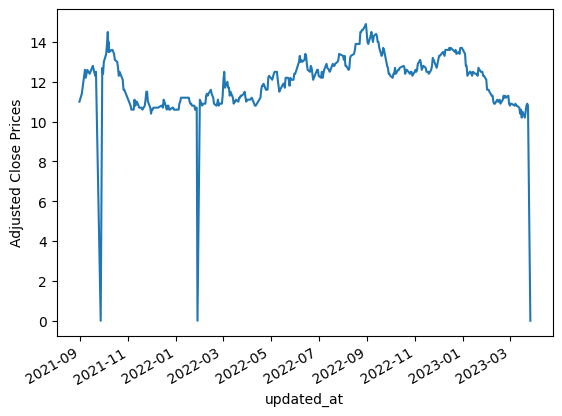

In [ ]:
df_bp['PriceATC'].plot()
plt.ylabel("Adjusted Close Prices")
plt.show()

## Data Cleansing 

Outlier Detection

In [ ]:
#IQR range
Q1 = df_bp.quantile(0.25)
Q3 = df_bp.quantile(0.75)
IQR = Q3 - Q1

outlier_step = IQR*1.5

#print(df_train_norm < (Q1 - 1.5 * IQR)) |(df_train_norm > (Q3 + 1.5 * IQR))        
df_bp = df_bp[~((df_bp < (Q1 - outlier_step)) |(df_bp > (Q3 + outlier_step))).any(axis=1)]

In [ ]:
df_bp.shape

(163, 15)

<Axes: xlabel='updated_at'>

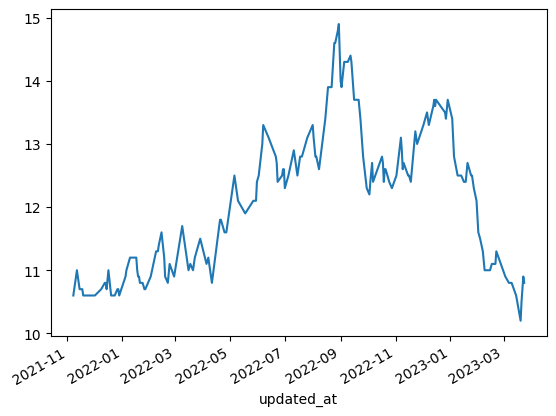

In [ ]:
df_bp['PriceATC'].plot.line()

## PriceATC predition 

### Split Data

In [ ]:
# Remove any missing values
df_bp.dropna(inplace=True)

# Create a feature matrix and target vector
X = df_bp.drop('PriceATC', axis=1)
y = df_bp['PriceATC']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Feature Importance

Base on Model

In [ ]:
# Create the decision tree model to calculate feature importance
tree_model = DecisionTreeRegressor(random_state=42)
tree_model.fit(X_train, y_train)

# Extract feature importances
importances = tree_model.feature_importances_
feature_names = X_train.columns.values

# Sort the features by importance
sorted_idx = importances.argsort()


df_feature_importance = pd.DataFrame({
                                                            'Score' : importances
 },index = feature_names)

df_feature_importance

,Score
VolATO1,3.787978e-04
PriceATO1,9.559172e-04
Close(T_1),2.106476e-03
VolATO2,0.000000e+00
PriceATO2,2.836835e-02
Price12_30,9.089599e-01
VolATC,4.545573e-05
Price16_30,5.909926e-02
PercentChgSS1,4.478689e-15
ValueSS1,4.040510e-05


<Axes: >

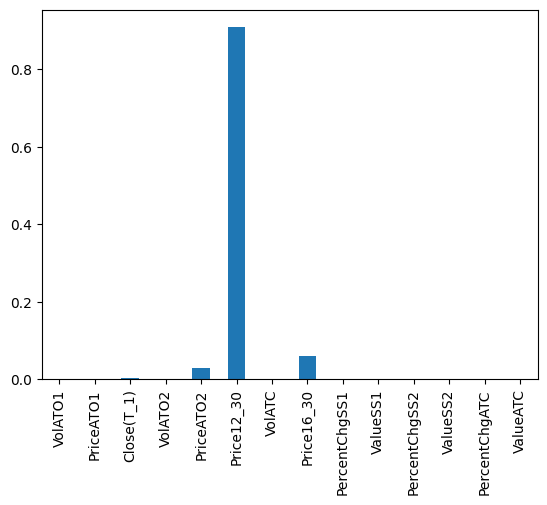

In [ ]:
df_feature_importance['Score'].plot.bar()

In [ ]:
# Select the top n important features
n = 3
top_n_features = feature_names[sorted_idx[-n:]]

# Create a new feature matrix with only the top n features
X_train_new = X_train[top_n_features]
X_test_new = X_test[top_n_features]

# Create the new model and fit it to the training data
new_model = DecisionTreeRegressor(random_state=42)
new_model.fit(X_train_new, y_train)

# Make predictions on the test data
y_pred = new_model.predict(X_test_new)

# Calculate the RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Root MSE  : {rmse} ')

Root MSE  : 0.07587869106393297 


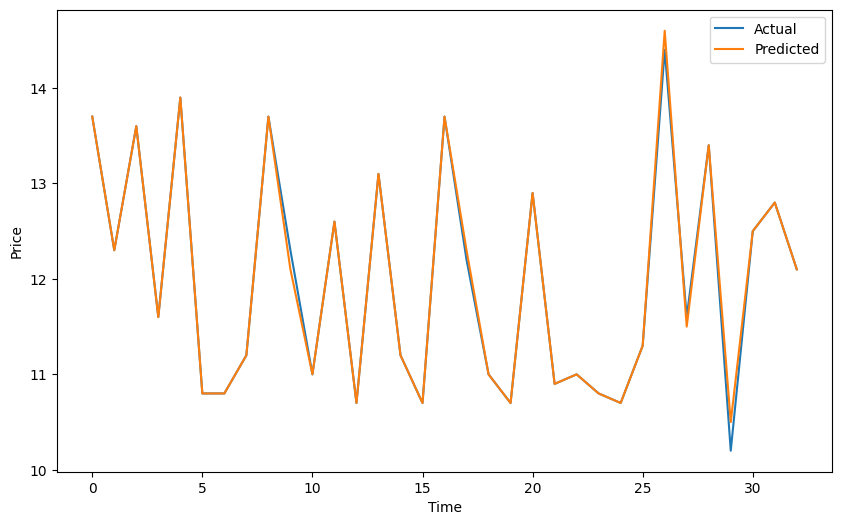

In [ ]:
# Plot the actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [ ]:
text_representation = tree.export_text(new_model)
print(text_representation)

|--- feature_1 <= 12.00
|   |--- feature_1 <= 11.05
|   |   |--- feature_1 <= 10.75
|   |   |   |--- feature_1 <= 10.65
|   |   |   |   |--- feature_1 <= 10.55
|   |   |   |   |   |--- value: [10.50]
|   |   |   |   |--- feature_1 >  10.55
|   |   |   |   |   |--- feature_2 <= 10.65
|   |   |   |   |   |   |--- value: [10.60]
|   |   |   |   |   |--- feature_2 >  10.65
|   |   |   |   |   |   |--- value: [10.60]
|   |   |   |--- feature_1 >  10.65
|   |   |   |   |--- value: [10.70]
|   |   |--- feature_1 >  10.75
|   |   |   |--- feature_1 <= 10.85
|   |   |   |   |--- feature_0 <= 10.85
|   |   |   |   |   |--- value: [10.80]
|   |   |   |   |--- feature_0 >  10.85
|   |   |   |   |   |--- value: [10.80]
|   |   |   |--- feature_1 >  10.85
|   |   |   |   |--- feature_1 <= 10.95
|   |   |   |   |   |--- value: [10.90]
|   |   |   |   |--- feature_1 >  10.95
|   |   |   |   |   |--- value: [11.00]
|   |--- feature_1 >  11.05
|   |   |--- feature_1 <= 11.45
|   |   |   |--- feature_1 <

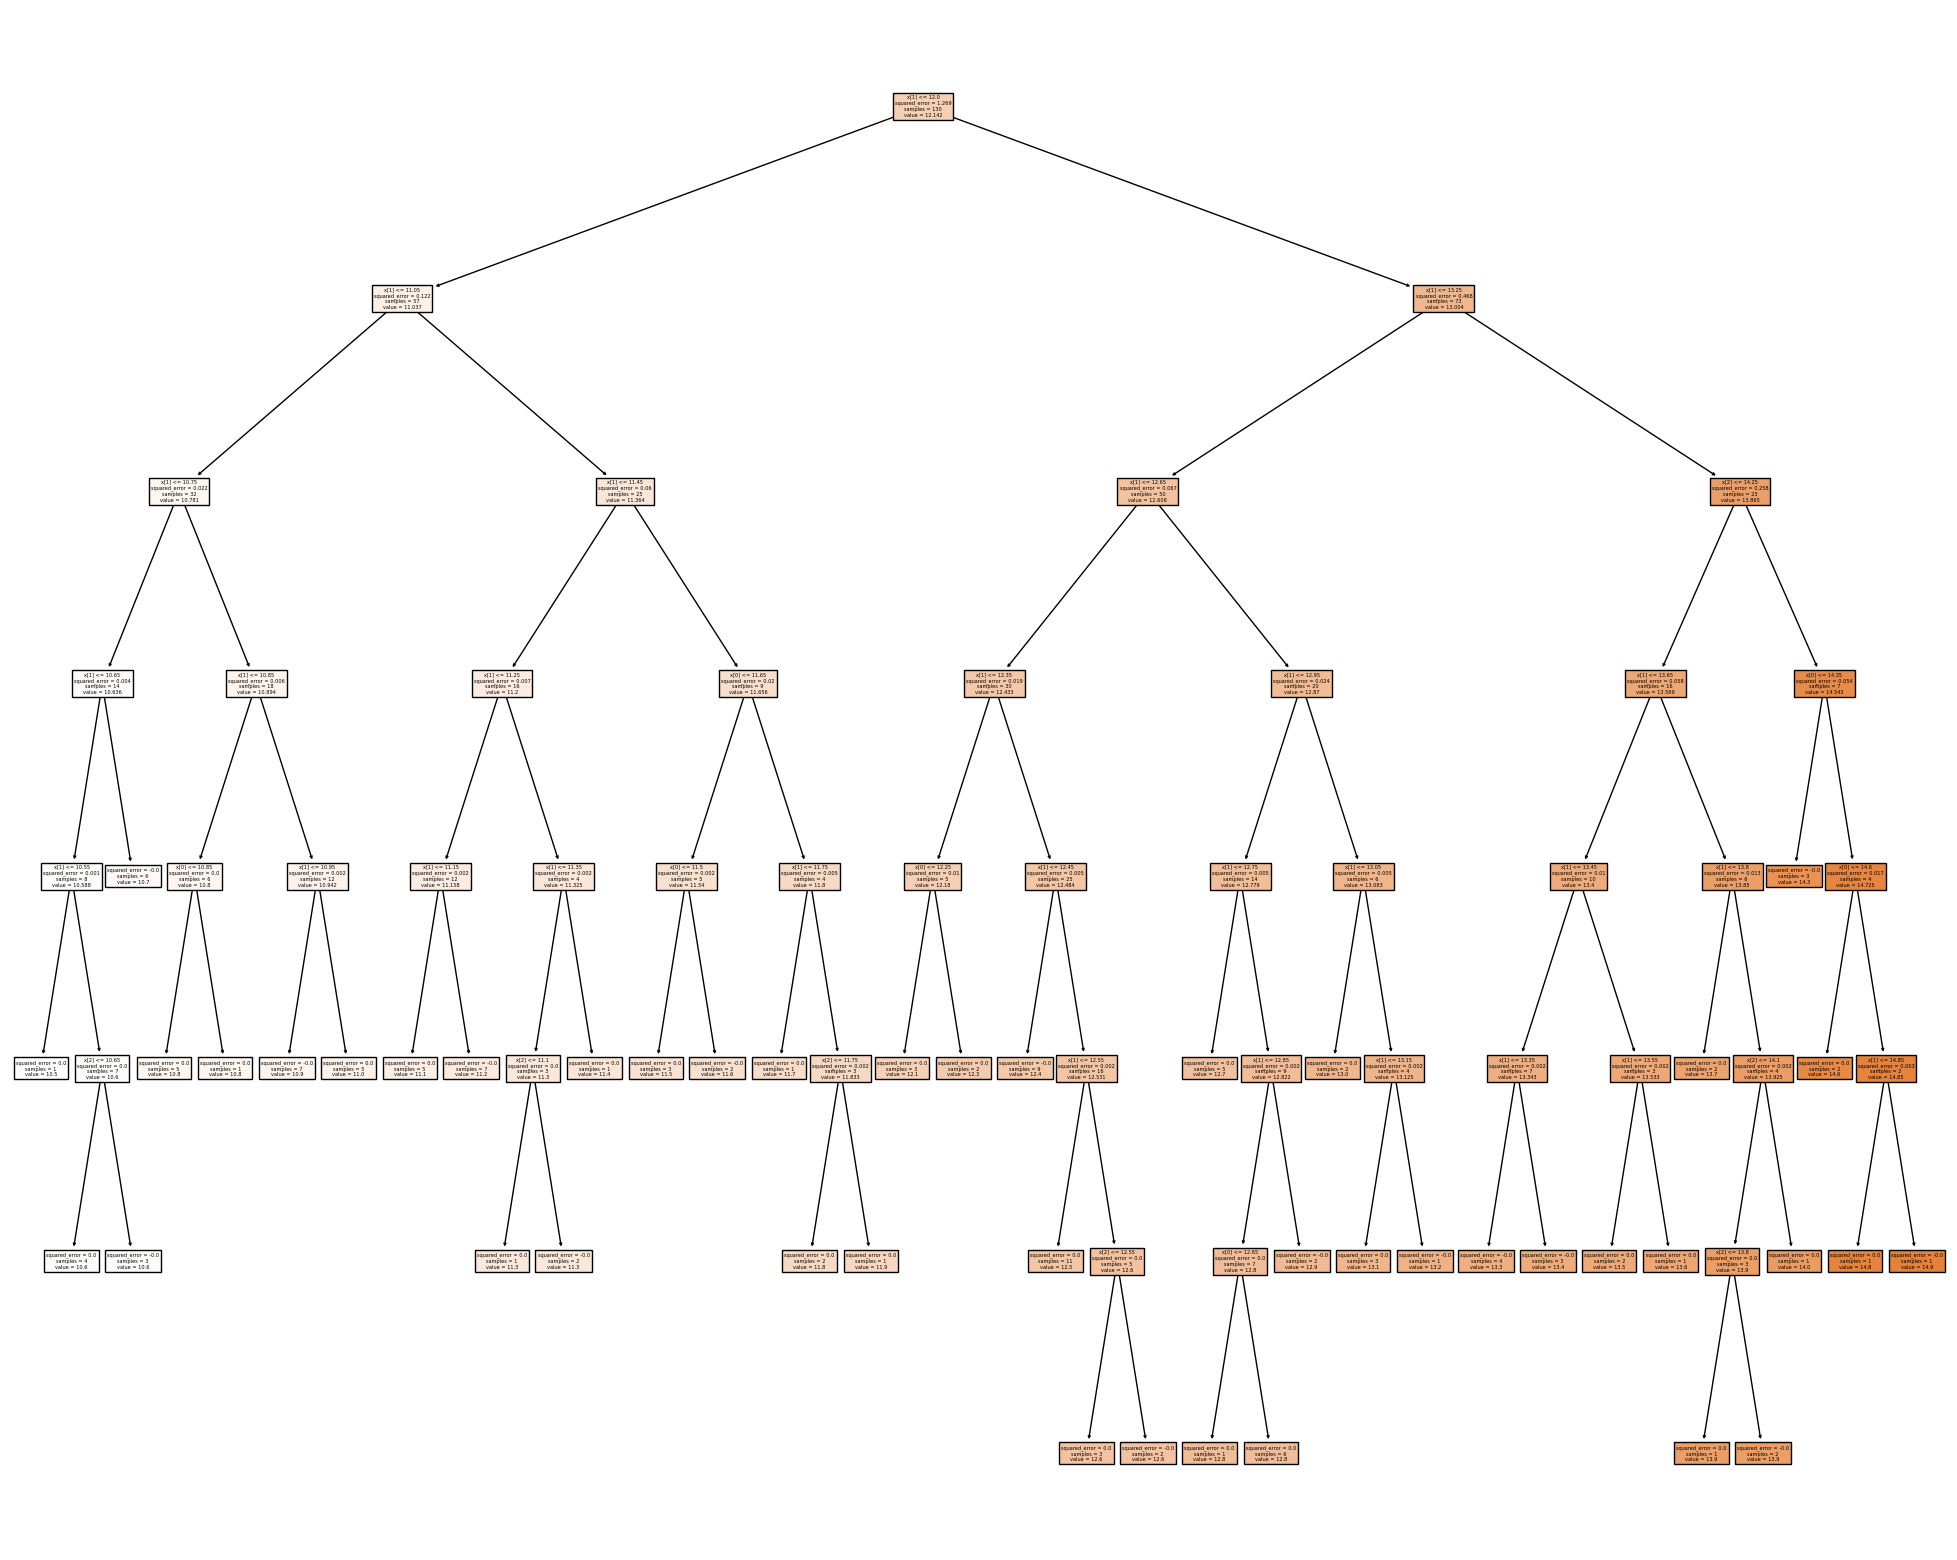

In [ ]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(new_model,filled=True)

In [ ]:
#import test data
df_test_bp = pd.read_csv('/content/gdrive/MyDrive/Pi data/Banpu_test_model.csv')

In [ ]:
df_test = df_test_bp.loc[::-1].reset_index(drop=True)

df_test = df_test.drop(index = 6).reset_index(drop=True)

In [ ]:
df_test

,_id,Symbol,VolATO1,PriceATO1,Close(T_1),VolATO2,PriceATO2,Price12_30,VolATC,PriceATC,Price16_30,PercentChgSS1,ValueSS1,PercentChgSS2,ValueSS2,PercentChgATC,ValueATC,updated_at
0,312739,BANPU,1319700,10.2,10.2,741000,10.2,10.3,69381600,10.5,10.4,0.00,13460940,-0.97,7558200,0.96,728506800,2023-03-17
1,313601,BANPU,1125000,10.3,10.5,2402600,10.3,10.3,5880700,10.2,10.2,-1.90,11587500,0.00,24746780,0.00,59983140,2023-03-20
2,314463,BANPU,690400,10.3,10.2,585600,10.3,10.4,17955500,10.5,10.5,0.98,7111120,-0.96,6031680,0.00,188532750,2023-03-21
3,315325,BANPU,1068500,10.6,10.5,1998800,10.8,10.8,100,10.8,10.7,0.95,11326100,0.00,21587040,0.93,1080,2023-03-22
4,316187,BANPU,1660200,10.7,10.7,680400,10.9,10.8,14635600,10.9,10.9,0.00,17764140,0.93,7416360,0.00,159528040,2023-03-23
5,317049,BANPU,308100,10.9,10.9,443300,10.8,10.9,7245200,10.8,10.8,0.00,3358290,-0.92,4787640,0.00,78248160,2023-03-24
6,318773,BANPU,1754700,10.8,10.8,969100,11.0,11.0,13403200,11.0,11.0,0.00,18950760,0.00,10660100,0.00,147435200,2023-03-28
7,319635,BANPU,447600,11.0,11.0,722000,11.0,10.9,7500,11.0,10.9,0.00,4923600,0.92,7942000,0.92,82500,2023-03-29
8,320497,BANPU,1417100,10.9,11.0,1074700,10.8,10.8,8553300,10.8,10.8,-0.91,15446390,0.00,11606760,0.00,92375640,2023-03-30


In [ ]:
#Evaluate on Real Data 10 days
x_test_predict = df_test[top_n_features]
y_test_predict = df_test['PriceATC']
y_pred_model = new_model.predict(x_test_predict)

Evaluate Model 

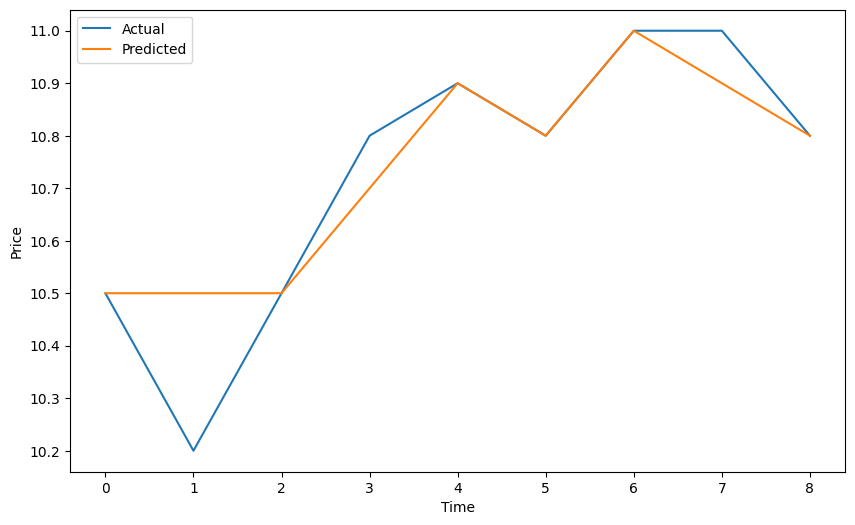

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(y_test_predict.values, label='Actual')
plt.plot(y_pred_model, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

K Best 

In [ ]:
BestFeatures = SelectKBest(score_func=f_classif, k=10)
fit = BestFeatures.fit(X_train,y_train)

df_scores = pd.DataFrame(fit.scores_)
df_columns = pd.DataFrame(X_train.columns)

f_Scores = pd.concat([df_columns,df_scores],axis=1)              
f_Scores.columns = ['features','Score']  

f_Score =  f_Scores.set_index('features')


/usr/local/lib/python3.9/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 7 12] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.9/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.9/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


<Axes: xlabel='features'>

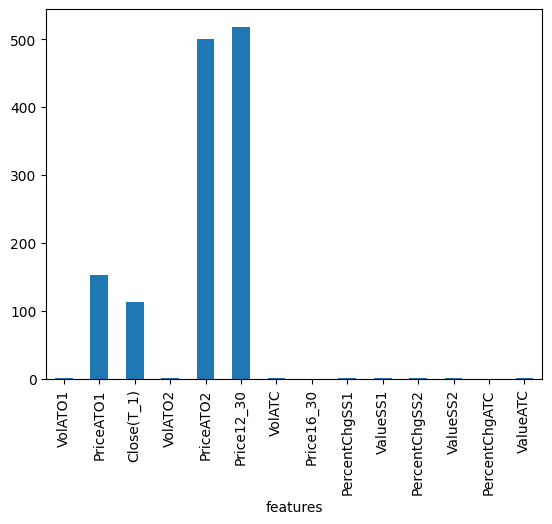

In [ ]:
f_Score['Score'].plot.bar()

In [ ]:
df_bp_drop = df_bp[['PriceATO1','Close(T_1)','PriceATO2','Price12_30','Price16_30']]

In [ ]:
df_bp.head()

,VolATO1,PriceATO1,Close(T_1),VolATO2,PriceATO2,Price12_30,VolATC,PriceATC,Price16_30,PercentChgSS1,ValueSS1,PercentChgSS2,ValueSS2,PercentChgATC,ValueATC
updated_at,,,,,,,,,,,,,,,
2021-11-08,2889200,10.7,10.6,548100,10.6,10.5,8671000,10.6,10.6,0.94,30914440,0.95,5809860,0.0,91912600
2021-11-12,1771600,11.1,11.0,119600,11.0,11.0,6776000,11.0,11.0,0.91,19664760,0.00,1315600,0.0,74536000
2021-11-15,1533000,11.0,11.0,634000,10.8,10.8,9228000,10.7,10.7,0.00,16863000,0.00,6847200,0.0,98739600
2021-11-16,995600,10.7,10.7,484500,10.8,10.8,6531300,10.7,10.7,0.00,10652920,0.00,5232600,0.0,69884910
2021-11-17,1096800,10.7,10.7,643600,10.7,10.6,10882200,10.7,10.7,0.00,11735760,0.94,6886520,0.0,116439540


In [ ]:
df_bp_drop

,PriceATO1,Close(T_1),PriceATO2,Price12_30,Price16_30
updated_at,,,,,
2021-11-08,10.7,10.6,10.6,10.5,10.6
2021-11-12,11.1,11.0,11.0,11.0,11.0
2021-11-15,11.0,11.0,10.8,10.8,10.7
2021-11-16,10.7,10.7,10.8,10.8,10.7
2021-11-17,10.7,10.7,10.7,10.6,10.7
...,...,...,...,...,...
2023-03-15,10.6,10.4,10.5,10.6,10.6
2023-03-20,10.3,10.5,10.3,10.3,10.2
2023-03-21,10.3,10.2,10.3,10.4,10.5


#ARIMA

These components are defined as follows:

-  Level: The average value in the series.
- Trend: The increasing or decreasing value in the series.
-  Seasonality: The repeating short-term cycle in the series.
- Noise: The random variation in the series.





Stationary using Dickey Fuller Test

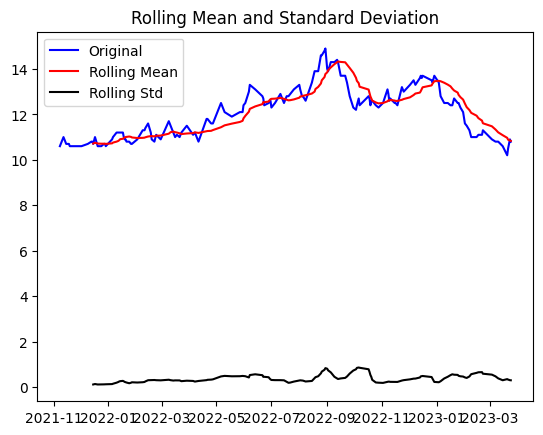

Results of dickey fuller test
Test Statistics                 -1.705234
p-value                          0.428418
No. of lags used                 0.000000
Number of observations used    162.000000
critical value (1%)             -3.471374
critical value (5%)             -2.879552
critical value (10%)            -2.576373
dtype: float64


In [ ]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(df_bp['PriceATC'])

<Figure size 640x480 with 0 Axes>

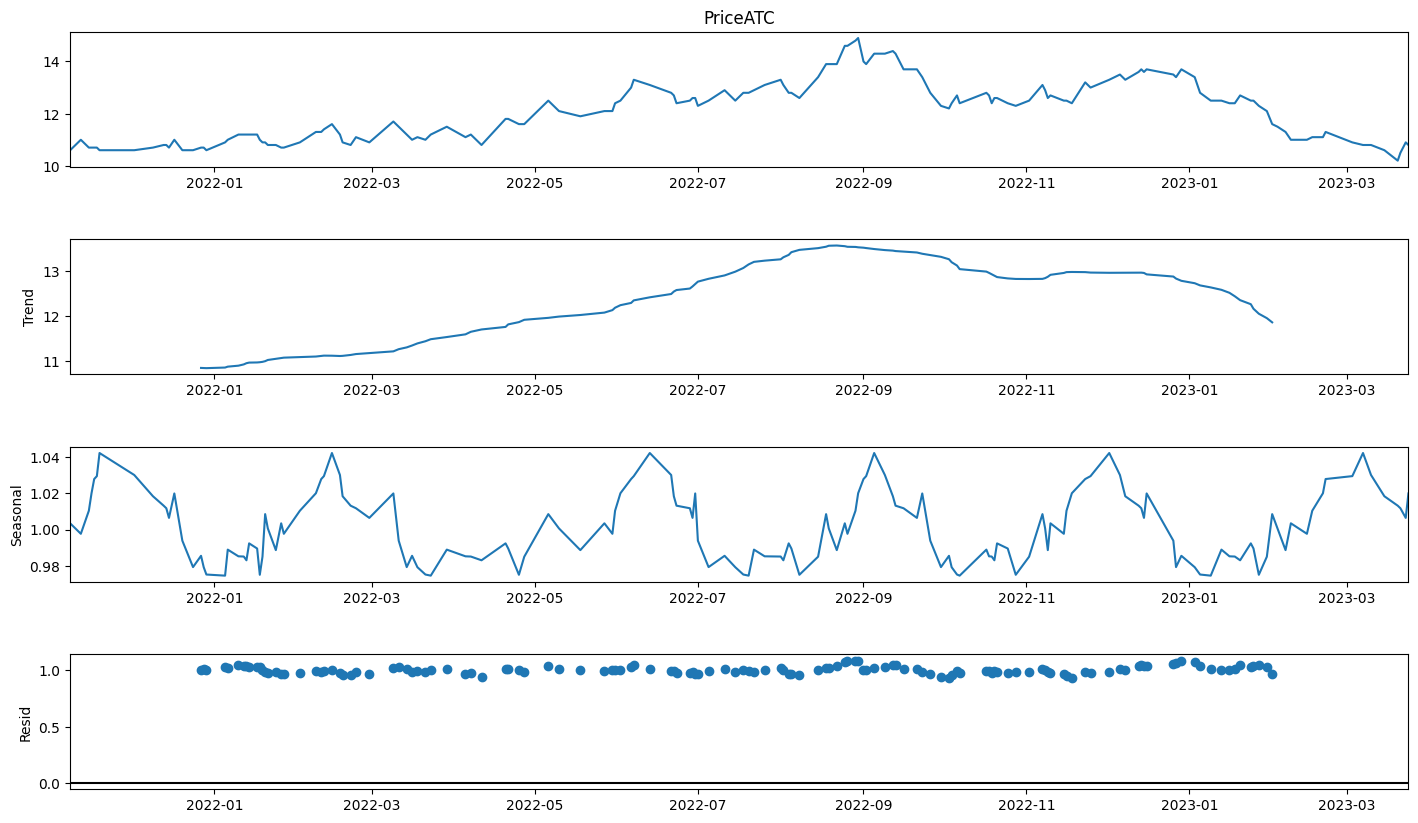

In [ ]:
df_close = df_bp['PriceATC']
result = seasonal_decompose(df_close, model='multiplicative',period = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

In [ ]:
df_close

updated_at
2021-11-08    10.6
2021-11-12    11.0
2021-11-15    10.7
2021-11-16    10.7
2021-11-17    10.7
              ... 
2023-03-15    10.6
2023-03-20    10.2
2023-03-21    10.5
2023-03-23    10.9
2023-03-24    10.8
Name: PriceATC, Length: 163, dtype: float64

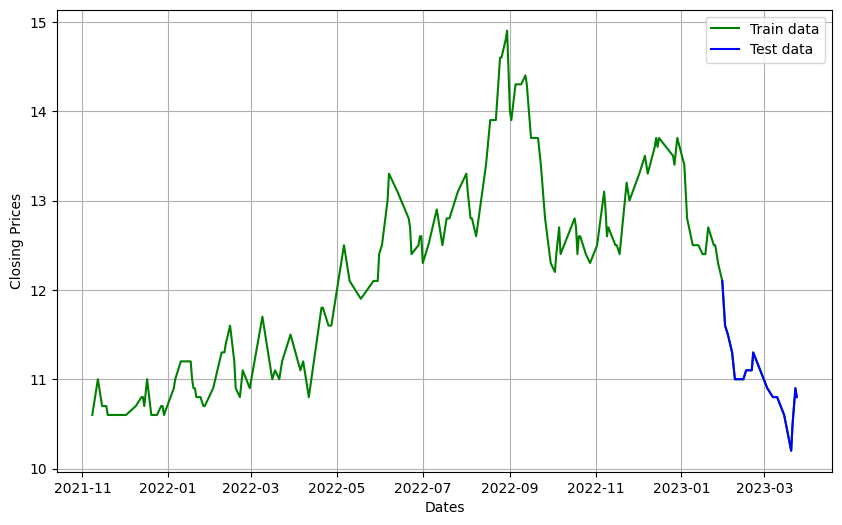

In [ ]:
train_data, test_data = df_close[3:int(len(df_close)*0.9)], df_close[int(len(df_close)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_close, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

In [ ]:
print(test_data.index[0])

2023-01-30 00:00:00


In [ ]:
model = ARIMA(train_data, order=(3, 1, 2))  
arima_bp = model.fit()  
print(arima_bp.summary())

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/l

                               SARIMAX Results                                
Dep. Variable:               PriceATC   No. Observations:                  143
Model:                 ARIMA(3, 1, 2)   Log Likelihood                 -25.161
Date:                Sun, 23 Apr 2023   AIC                             62.322
Time:                        16:19:01   BIC                             80.057
Sample:                             0   HQIC                            69.529
                                - 143                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1944      0.107     -1.817      0.069      -0.404       0.015
ar.L2         -0.9665      0.059    -16.395      0.000      -1.082      -0.851
ar.L3          0.0143      0.106      0.134      0.8

/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
!pip install prophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
df_bp.head()

,VolATO1,PriceATO1,Close(T_1),VolATO2,PriceATO2,Price12_30,VolATC,PriceATC,Price16_30,PercentChgSS1,ValueSS1,PercentChgSS2,ValueSS2,PercentChgATC,ValueATC
updated_at,,,,,,,,,,,,,,,
2021-11-08,2889200,10.7,10.6,548100,10.6,10.5,8671000,10.6,10.6,0.94,30914440,0.95,5809860,0.0,91912600
2021-11-12,1771600,11.1,11.0,119600,11.0,11.0,6776000,11.0,11.0,0.91,19664760,0.00,1315600,0.0,74536000
2021-11-15,1533000,11.0,11.0,634000,10.8,10.8,9228000,10.7,10.7,0.00,16863000,0.00,6847200,0.0,98739600
2021-11-16,995600,10.7,10.7,484500,10.8,10.8,6531300,10.7,10.7,0.00,10652920,0.00,5232600,0.0,69884910
2021-11-17,1096800,10.7,10.7,643600,10.7,10.6,10882200,10.7,10.7,0.00,11735760,0.94,6886520,0.0,116439540


In [ ]:
df_bp['PriceATC']

updated_at
2021-11-08    10.6
2021-11-12    11.0
2021-11-15    10.7
2021-11-16    10.7
2021-11-17    10.7
              ... 
2023-03-15    10.6
2023-03-20    10.2
2023-03-21    10.5
2023-03-23    10.9
2023-03-24    10.8
Name: PriceATC, Length: 163, dtype: float64

In [ ]:
df_bp = df_bp.reset_index()

In [ ]:
# Select only the important features i.e. the date and price
df_bp_pp = df_bp[["updated_at","PriceATC"]] # select Date and Price
# Rename the features: These names are NEEDED for the model fitting
df_bp_pp = df_bp_pp.rename(columns = {"updated_at":"ds","PriceATC":"y"}) #renaming the columns of the dataset

df_bp_pp

,ds,y
0,2021-11-08,10.6
1,2021-11-12,11.0
2,2021-11-15,10.7
3,2021-11-16,10.7
4,2021-11-17,10.7
...,...,...
158,2023-03-15,10.6
159,2023-03-20,10.2
160,2023-03-21,10.5
161,2023-03-23,10.9


In [ ]:
from prophet import Prophet
m = Prophet(daily_seasonality = True) # the Prophet class (model)
m.fit(df_bp_pp) # fit the model using all data

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp422qapnq/t09ak42_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp422qapnq/wpkca7ua.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27522', 'data', 'file=/tmp/tmp422qapnq/t09ak42_.json', 'init=/tmp/tmp422qapnq/wpkca7ua.json', 'output', 'file=/tmp/tmp422qapnq/prophet_model8dqabkbp/prophet_model-20230423161907.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:19:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:19:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


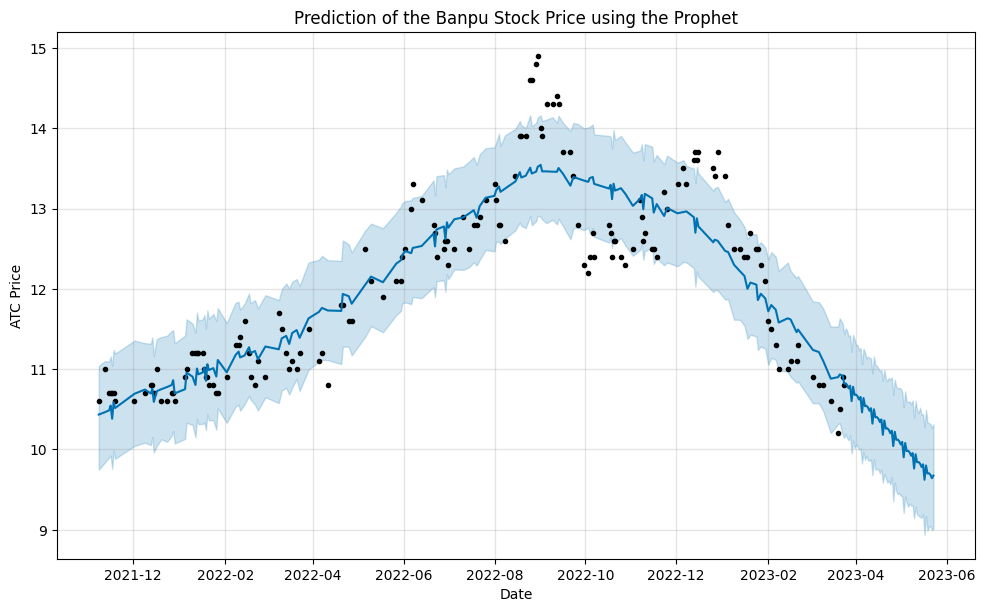

In [ ]:
future = m.make_future_dataframe(periods=60) #we need to specify the number of days in future
prediction = m.predict(future)
m.plot(prediction)
plt.title("Prediction of the Banpu Stock Price using the Prophet")
plt.xlabel("Date")
plt.ylabel("ATC Price")
plt.show()

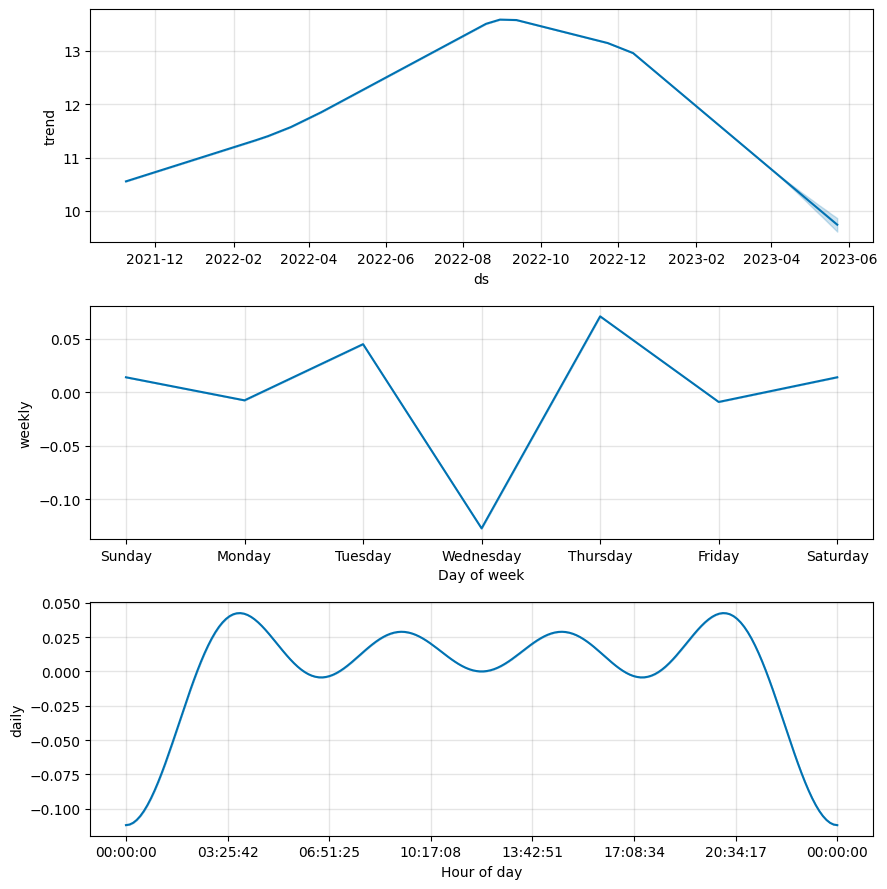

In [ ]:
m.plot_components(prediction)
plt.show()

In [ ]:
df = pd.read_

In [ ]:
df_ba['bid_ask_vol_ratio'] = df['Volume Bid'] / df['Volume Ask']

# Create a line chart of the bid-ask volume ratio over time
plt.plot(df['Date'], df['bid_ask_vol_ratio'])
plt.xlabel('Date')
plt.ylabel('Bid-Ask Volume Ratio')
plt.title('Apple (AAPL) Bid-Ask Volume Ratio')
plt.show()